# Machine Learning Engineer Nanodegree

## Service Request Analysis Report

### Udacity

#### June 1st, 2018

##  Load Data - Train Model


### Import libraries ###

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt

import nltk
# nltk.download()
from nltk.corpus import stopwords

# Pretty display for notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# featuretools for automated feature engineering
import featuretools as ft

https://catalog.data.gov/dataset/consumer-complaint-database

### Variables

In [3]:
categories_to_predict = ['Product_code']
stop_words = set(stopwords.words('english'))

## Load data

In [4]:
## Load data - Service request data 
## https://catalog.data.gov/dataset/consumer-complaint-database

df = pd.read_csv("data/Consumer_Complaints.csv")
df.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760
5,11/13/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,U.S. BANCORP,MN,48322,NaN,NaN,Phone,11/20/2013,Closed with monetary relief,Yes,No,596562
6,6/16/2015,Debt collection,Medical,Improper contact or sharing of info,Contacted employer after asked not to,NaN,Company believes it acted appropriately as aut...,California Accounts Service,CA,92111,NaN,Consent not provided,Web,6/19/2015,Closed with explanation,Yes,No,1422680
7,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,Company chooses not to provide a public response,Experian Information Solutions Inc.,VA,224XX,NaN,Consent provided,Web,6/15/2015,Closed with explanation,Yes,No,1420702
8,11/13/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Aldridge Pite, LLP",CA,93101,NaN,NaN,Referral,12/10/2015,Closed with explanation,Yes,Yes,1654890
9,10/21/2014,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,OCWEN LOAN SERVICING LLC,FL,32714,Older American,NaN,Web,10/21/2014,Closed with explanation,Yes,No,1079567


In [5]:
# data frame details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
Date received                   1048575 non-null object
Product                         1048575 non-null object
Sub-product                     813737 non-null object
Issue                           1048575 non-null object
Sub-issue                       549612 non-null object
Consumer complaint narrative    288291 non-null object
Company public response         329512 non-null object
Company                         1048575 non-null object
State                           1035908 non-null object
ZIP code                        1031409 non-null object
Tags                            144311 non-null object
Consumer consent provided?      510889 non-null object
Submitted via                   1048575 non-null object
Date sent to company            1048575 non-null object
Company response to consumer    1048571 non-null object
Timely response?                1048575 non-null obje

In [6]:
# df.info()
df.columns.unique()

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

## Pre-process data

In [7]:
## Remove missing values in 'consumer complaint narrative'
df = df[pd.notnull(df)['Consumer complaint narrative']]
df.head(4)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
7,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,Company chooses not to provide a public response,Experian Information Solutions Inc.,VA,224XX,NaN,Consent provided,Web,6/15/2015,Closed with explanation,Yes,No,1420702
12,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,NaN,"The CBE Group, Inc.",TX,752XX,NaN,Consent provided,Web,2/3/2016,Closed with explanation,Yes,Yes,1772196


In [8]:
cat = ['Product','Consumer complaint narrative']
df_cat = df[cat]
df_subprod = df['Sub-product'].value_counts()
df_product = df['Product'].value_counts()
df_issue = df['Issue'].value_counts()
df_company = df['Company'].value_counts()

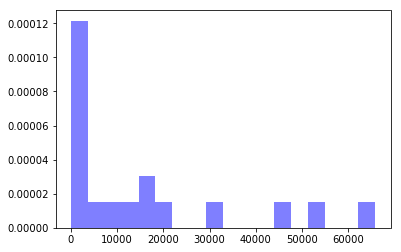

In [9]:
num_bins = 18
# df_count = df.info()
# Distribution of Product 
n, bins, patches = plt.hist(df_product, num_bins, normed=1, facecolor='blue', alpha=0.5)
# plt.hist(df_prod, num_bins, normed=1, facecolor='blue', alpha=0.5)
# n, bins, patches = plt.hist(df_issue, num_bins, normed=1, facecolor='blue', alpha=0.5)
# n, bins, patches = plt.hist(df_company, num_bins, normed=1, facecolor='blue', alpha=0.5)

(array([3.58337744e-04, 7.74784311e-07, 9.68480389e-08, 3.87392156e-07,
        9.68480389e-08, 0.00000000e+00, 0.00000000e+00, 1.93696078e-07,
        0.00000000e+00, 9.68480389e-08]),
 array([1.00000e+00, 2.77890e+03, 5.55680e+03, 8.33470e+03, 1.11126e+04,
        1.38905e+04, 1.66684e+04, 1.94463e+04, 2.22242e+04, 2.50021e+04,
        2.77800e+04]),
 <a list of 10 Patch objects>)

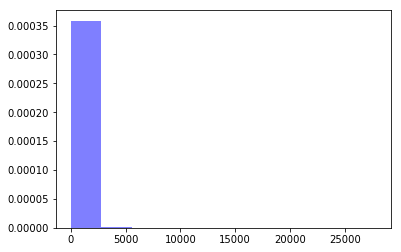

In [10]:
# distribution of company in histogram
plt.hist(df_company, normed=1, facecolor='blue', alpha=0.5)

In [11]:
## Convert Product type as category
df_cat["Product"] = df_cat["Product"].astype('category')
df_cat.dtypes

Product                         category
Consumer complaint narrative      object
dtype: object

In [12]:
df_cat["Product_Code"] = df_cat["Product"].cat.codes

In [13]:
counts = []
categories = list(df_cat.values)

In [14]:
# count unique values for product
df_idx = df_cat.set_index('Product')
df_idx.nunique
# df_cat.nunique


<bound method DataFrame.nunique of                                                                          Consumer complaint narrative  \
Product                                                                                                 
Credit reporting                                    I have outdated information on my credit repor...   
Consumer Loan                                       I purchased a new car on XXXX XXXX. The car de...   
Credit reporting                                    An account on my credit report has a mistaken ...   
Debt collection                                     This company refuses to provide me verificatio...   
Debt collection                                     This complaint is in regards to Square Two Fin...   
Mortgage                                            Started the refinance of home mortgage process...   
Mortgage                                            In XXXX, I and my ex-husband applied for a ref...   
Credit reporting    

### Explorotary Data Analysis

In [15]:
# Total number of records
n_records = len(df_cat)


In [16]:
es = ft.EntitySet(id = "ServiceRequests")
es = es.entity_from_dataframe(entity_id = "ServiceRequests", dataframe = df_cat,  
                              index = "Unique Key")

2018-07-10 19:56:02,934 featuretools.entityset - WARNING    index Unique Key not found in dataframe, creating new integer column


## Select 'TEXT' column and remove poorly represented classes

A machine learning model can only learn from the data we give it, and making sure that data is relevant to the task is one of the most crucial steps in the machine learning pipeline 


In [17]:
# Visualize skewed continuous features of original data

df_cat

,Product,Consumer complaint narrative,Product_Code
1,Credit reporting,I have outdated information on my credit repor...,5
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,2
7,Credit reporting,An account on my credit report has a mistaken ...,5
12,Debt collection,This company refuses to provide me verificatio...,7
16,Debt collection,This complaint is in regards to Square Two Fin...,7
25,Mortgage,Started the refinance of home mortgage process...,10
26,Mortgage,"In XXXX, I and my ex-husband applied for a ref...",10
28,Credit reporting,I have disputed several accounts on my credit ...,5
29,Mortgage,Mortgage was transferred to Nationstar as of X...,10
36,Credit card,"Was a happy XXXX card member for years, in lat...",3


### The distribution of the number of words in comment texts.

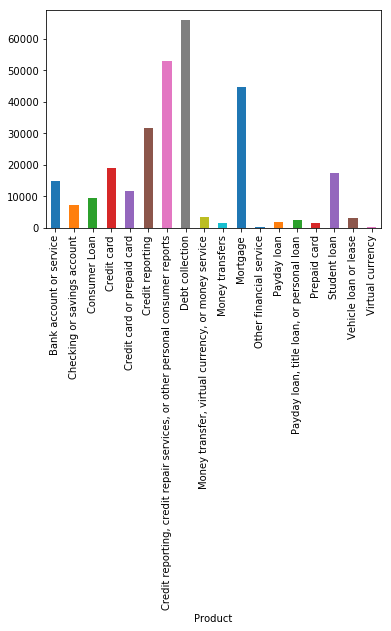

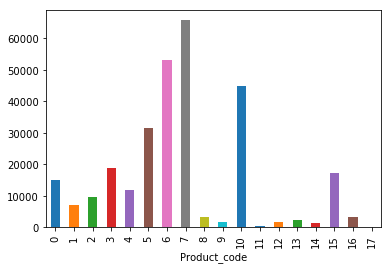

In [18]:
# Categories in data frame
df_cat.columns = ['Product', 'complaint', 'Product_code']
# Count the columns of the Product 
df_cat.groupby('Product').complaint.count().plot.bar(ylim=0)
plt.show()
# Plot the columns of the Product code
df_cat.groupby('Product_code').complaint.count().plot.bar(ylim=0)

In [19]:
df_prod = df_cat.drop('complaint', axis=1)
df_prod

product_to_productcode = dict(df_prod.values)
productcode_to_product = dict(df_prod[['Product_code', 'Product']].values)
# product_to_productcode
productcode_to_product

{0: 'Bank account or service',
 1: 'Checking or savings account',
 2: 'Consumer Loan',
 3: 'Credit card',
 4: 'Credit card or prepaid card',
 5: 'Credit reporting',
 6: 'Credit reporting, credit repair services, or other personal consumer reports',
 7: 'Debt collection',
 8: 'Money transfer, virtual currency, or money service',
 9: 'Money transfers',
 10: 'Mortgage',
 11: 'Other financial service',
 12: 'Payday loan',
 13: 'Payday loan, title loan, or personal loan',
 14: 'Prepaid card',
 15: 'Student loan',
 16: 'Vehicle loan or lease',
 17: 'Virtual currency'}

### Split data into train and test

In [20]:
df_catt=df_cat[['Product_code','Product']]
df_catt = df_catt.set_index('Product_code')

pd.unique((df_cat[['Product_code','Product']]).values.ravel())


array([5, 'Credit reporting', 2, 'Consumer Loan', 7, 'Debt collection',
       10, 'Mortgage', 3, 'Credit card', 11, 'Other financial service', 0,
       'Bank account or service', 15, 'Student loan', 9,
       'Money transfers', 12, 'Payday loan', 14, 'Prepaid card', 8,
       'Money transfer, virtual currency, or money service', 6,
       'Credit reporting, credit repair services, or other personal consumer reports',
       1, 'Checking or savings account', 16, 'Vehicle loan or lease', 4,
       'Credit card or prepaid card', 17, 'Virtual currency', 13,
       'Payday loan, title loan, or personal loan'], dtype=object)

In [21]:
df_cat.head(15)
# labelData = df_sr_cat[categories_to_predict]

,Product,complaint,Product_code
1,Credit reporting,I have outdated information on my credit repor...,5
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,2
7,Credit reporting,An account on my credit report has a mistaken ...,5
12,Debt collection,This company refuses to provide me verificatio...,7
16,Debt collection,This complaint is in regards to Square Two Fin...,7
25,Mortgage,Started the refinance of home mortgage process...,10
26,Mortgage,"In XXXX, I and my ex-husband applied for a ref...",10
28,Credit reporting,I have disputed several accounts on my credit ...,5
29,Mortgage,Mortgage was transferred to Nationstar as of X...,10
36,Credit card,"Was a happy XXXX card member for years, in lat...",3


In [22]:
labelData = df_cat[categories_to_predict]
productcode = df_cat['Product_code']
product = df_cat['Product']
ServiceRequests = df_cat['complaint']
# x_train, x-test, y_train, y_test
train_data, test_data, train_labels, test_labels = train_test_split(ServiceRequests, 
                                                                    productcode, 
                                                                    test_size = 0.2, 
                                                                    random_state = 22)

In [23]:
X_train = train_data
# train_data['Complaint Type']
                     
X_test = test_data
# ['Complaint Type']
                     
X_train.head()
print(X_train.shape)

Y_train = train_labels
Y_test =  test_labels
            
                     
print(train_data[:10])
print(train_labels[:10])
                     

(230632,)
959616     My electric payment from XXXX XXXX posted on m...
1046368    We accept debit/credit cards for goods and ser...
689584     My name is XXXX XXXX I have a mortgage with Ci...
434683     I disputed a couple of accounts that showed as...
767906     I sent a letter with Texas State guidelines fo...
1043859    There is a closed account from XXXX, Account #...
872173     I was contacted by I.Q. Data International by ...
683941     I draw a low goverment check each month. No go...
992243     MY HOME LOAN WAS SERVICED BY XXXX XXXX AND THE...
53512      Was contacted 3 weeks ago and set up a payment...
Name: complaint, dtype: object
959616      1
1046368     0
689584     10
434683      5
767906      7
1043859     6
872173      7
683941     12
992243     10
53512       7
Name: Product_code, dtype: int8


In [24]:
print(train_data.shape)
print(train_labels.shape)

(230632,)
(230632,)


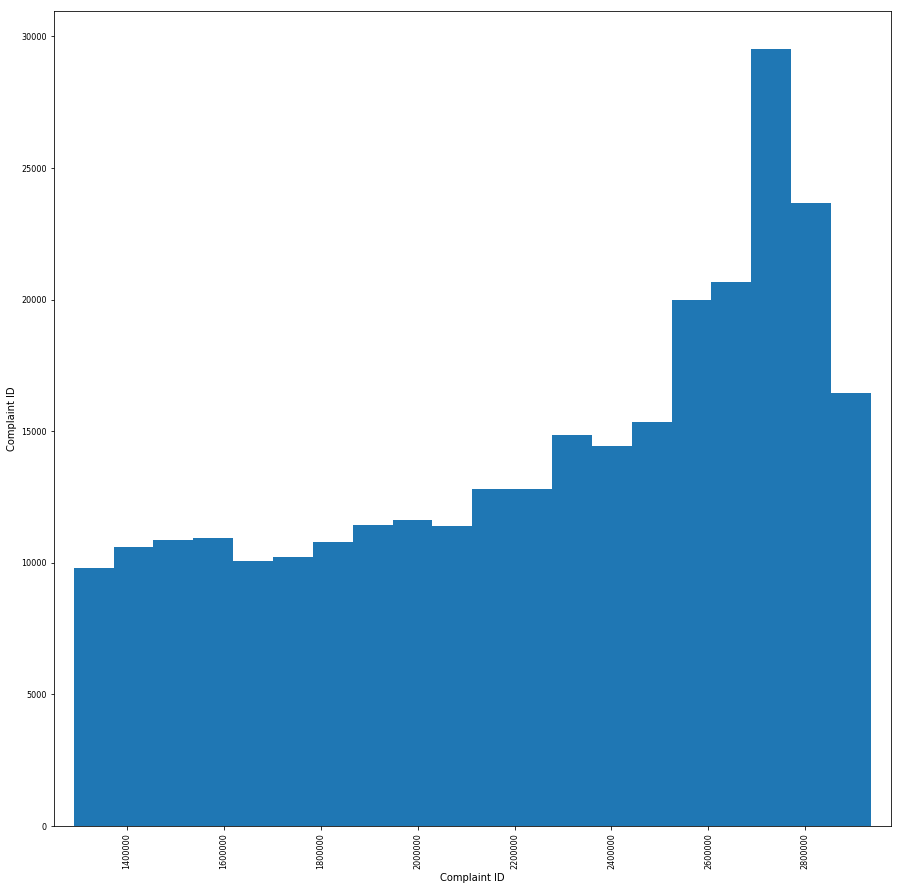

In [25]:
# create a scatter matrix from the dataframe, color by y_train
scat_plot = pd.scatter_matrix(df, c=Y_train, figsize=(15,15),marker = 'o', hist_kwds={'bins':20},s=60, alpha=0.8)


In [26]:
print("Complaints / Requests :\n{}".format(X_train[:2]))

Complaints / Requests :
959616     My electric payment from XXXX XXXX posted on m...
1046368    We accept debit/credit cards for goods and ser...
Name: complaint, dtype: object


In [27]:
#corpus = df_sr_cat["complaint"]
X_train = train_data[:20000]
Y_train = train_labels[:20000]

In [28]:
X_train[2]

"I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had been paid in full ( dated XXXX, XXXX ) but no refund check was included. XXXX stated that they hold any over payment for 10 business days after the loan was satisfied and that my check would be mailed o

In [29]:
Y_train.head

<bound method NDFrame.head of 959616      1
1046368     0
689584     10
434683      5
767906      7
1043859     6
872173      7
683941     12
992243     10
53512       7
762655      5
767055      7
56688       5
260581     10
196182      7
935540      6
588495      3
645894      5
495920     10
347358      7
869363      7
399633      5
113806     10
983440      6
1013037     6
1044106     8
963547      6
272624      7
108227      6
823346     10
           ..
878282      6
622980     15
820091      6
739444      3
171737      0
196674      5
776206      2
971694      6
920146      6
505663     10
315287      2
430        10
1033944     6
978942     15
750632      3
632583      5
519048      5
837636      6
898347      7
737231      7
587035     10
277800      2
832504      7
988095      7
857326      4
955909      6
978392      8
743723     10
124610      0
348841      3
Name: Product_code, Length: 20000, dtype: int8>

## Extracting features from text

### Vectorize 

In [30]:
# corpus = df_sr_cat["complaint"]
# corpus1 = corpus[:20000]
corpus1 = X_train[:20000]
Y_train = Y_train[:20000]
vectorizer = CountVectorizer(min_df=1)

# print("Corpus =",corpus1)
# print("Vecorize =",vectorizer)

train_data_counts = vectorizer.fit_transform(train_data)
train_data_counts.shape


print(ServiceRequests)
# vect_ServiceRequests.shape


1          I have outdated information on my credit repor...
2          I purchased a new car on XXXX XXXX. The car de...
7          An account on my credit report has a mistaken ...
12         This company refuses to provide me verificatio...
16         This complaint is in regards to Square Two Fin...
25         Started the refinance of home mortgage process...
26         In XXXX, I and my ex-husband applied for a ref...
28         I have disputed several accounts on my credit ...
29         Mortgage was transferred to Nationstar as of X...
36         Was a happy XXXX card member for years, in lat...
43         Without provocation, I received notice that my...
49         I am writing to request your assistance in loo...
61         I am disputing the inaccurate information the ...
64         Checked my credit report after filing complain...
69         Need to move into a XXXX facility. Can no long...
80         I attempted to open a XXXX XXXX account on XXX...
83         Experian allo

In [31]:
# ServiceRequests.head
train_data.head(5)

959616     My electric payment from XXXX XXXX posted on m...
1046368    We accept debit/credit cards for goods and ser...
689584     My name is XXXX XXXX I have a mortgage with Ci...
434683     I disputed a couple of accounts that showed as...
767906     I sent a letter with Texas State guidelines fo...
Name: complaint, dtype: object

In [32]:
train_labels.shape

(230632,)

In [33]:
vectorizer.vocabulary_.get(u'algorithm')

6866

## Calculate tf and tf–idf

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
# tf_transformer = TfidfTransformer(use_idf=False).fit(train_data_counts)
# train_data_tf = tf_transformer.transform(train_data_counts)
# train_data_tf.shape

tfidf_transformer = TfidfTransformer()
train_data_tfidf = tfidf_transformer.fit_transform(train_data_counts)
train_data_tfidf.shape

(230632, 91527)

## Training Classifier

In [35]:
test_data.head(3)

493080    Someone has used my identity to open multiple ...
929599    I had a new car loan through XXXX ( Nissan Mot...
965076    I have already contacted XXXX about a card the...
Name: complaint, dtype: object

In [36]:
# Use Miltinomial Naives Bayes classifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf = clf.fit(train_data_tfidf, train_labels)

In [37]:
test_data = test_data[:1000]
test_label = test_labels[:1000]

In [89]:
# Test the prediction of classifier 
predict = clf.predict(vectorizer.transform(test_data))
predict1 = clf.predict(vectorizer.transform(['Why is this account in my credit report? It was paid in full in 2013. XXXX is ruining my credit report!']))
print(" Product Code predicted =", predict1)


 Product Code predicted = [6]


In [90]:
# Test the prediction of classifier 
predict1 = clf.predict(vectorizer.transform(['I have an open and current mortgage with Chase Bank # XXXX. Chase is reporting the loan payments to XXXX but XXXX is surpressing the information and reporting the loan as Discharged in BK. This mortgage was reaffirmed in a Chapter XXXX BK discharged dated XXXX/XXXX/2013. Chase keeps referring to BK Law for Chapter XXXX and we keep providing documentation for Chapter XXXX, and the account should be open and current with all the payments']))
print(" Product Code predicted =", predict1)            
                       

 Product Code predicted = [10]


In [91]:
predict1 = clf.predict(vectorizer.transform(['Initially, I went to make a purchase through XXXX that subscribes to a service called Verified by XXXX, to complete the purchase you must provide your password, which I entered, and entered again and again and it was nt accepted. I then tried to reset the password and provided all the needed info, again multiple times, each time it was rejected. Since it was declined, I went and purchased the items elsewhere on a different card. Then I find that they went ahead and completed the transaction even after all the rejections and telling me I was providing wrong info. I then sent a message to Compass Bank through their on-line banking system, which they deleted. Sent another message about it, and have continued to send messages daily to the bank for a week now. Each time I send a message, I get a response stating they will try and respond within one business day, it is now at XXXX messages and not a single response. Have a feeling they want me to call and deal with this over the phone as that provides them with deniability as there have been other issues in the past. i.e. I signed up at Compass Bank under an offer that was mailed to me which promised free checking for life. A couple years later they changed this and started charging me, when I challenged them on this, they asked for a copy of the letter, my reply was that they had attached it to the original paperwork opening the account. I then called another branch and asked if they maintain the original paperwork on accounts and was told yes. I then proceeded to the original bank branch and told them I had been told they maintain this paperwork, they replied yes, it s a banking requirement , but then I provided my ID and lo and behold, my paperwork had vanished ... ..and of course no offer was made to attempt to find it. Will add but a few of the screenshots showing that the messages have been sent acknowledged and ignored']))
print(" Product Code predicted =", predict1)

 Product Code predicted = [7]


In [92]:
predict1 = clf.predict(vectorizer.transform(['Around XXXX we consolidated our loans and paid off a loan to Chrysler financial fAround XXXX we consolidated our loans and paid off a loan to Chrysler financial fAround XXXX we consolidated our loans and paid off a loan to Chrysler financial for an automotive loan. In XX/XX/XXXX we applied for a lost title at our local town office in Tennessee. At this time it was made known to us that TD Financial XXXX XXXX XXXX XXXX XXXX lien on our title. I was directed to TD financial XXXX XXXX, then to My title Support XXXX, and back to TD financial to find that there is a " balance due of {$85.00} '' for " charges and fees ''. I have NEVER received any notifications from XXXX, TD Auto Finance or any other representative in the TEN to TWELVE YEARS since that loan was paid off. TD Auto Finance is located in XXXX Maine and I have never transacted business with them. I requested a supervisor call me to discuss the " balance due '' on XXXX/XXXX/15, and 1 week has passed with no response despite the XXXX calls I have placed to their " customer service department '' I find it very concerning and unethical that a corporation can quietly hold a " balance due '' for more than 10 years and then demand a consumer pay']))

print(" Product Code predicted =", predict1)

 Product Code predicted = [10]


In [93]:
predict1 = clf.predict(vectorizer.transform(['I have paid all copays and just rec d a bill from a collection agency. I have never rec d anything in the mail before on this. I called the Dr offfice and they say it was because visits that are being billed didnt have a referral but I always had a referral and if they told me that I would have gotten XXXX. I have attached proof that my primary care physician did send referrals. I feel as though this is some sort of way for them to bill people almost 5 years later knowing they will pay or it will kill their credit. I am in the XXXX and will be forced to pay something that is not accurate almost 5 years after the services']))

print(" Product Code predicted =", predict1)

 Product Code predicted = [7]


In [43]:

print("Predict =", predict.shape)
print(predict)


Predict = (1000,)
[ 6  6  6 10  6 10 10 10  6  6  6  7  6  7  7  7  6  6  6  7  7 10 10  6
  7 10  3  7  5  7  6  7  6  7 10  7  6  7 15  0  6  7  7  7  6  7 10  7
  7 10  7  6  6  7 10 10 10 10  7 10  6  6  0  6 10 10  6 10  7  6  7  3
  7  7 10 10  6  6 15  7  7 10 10  7  6  7  7 10 10  7  7  7  7  7  7  7
 10  6  6  6  7 10  6  7  7  6  6  7  6  7  6  6  7  0 10  7 10 10  6 10
  7  6  6  7  3 15  7  6  7  7  6  6  6  7 10  6  7 10 10  6  7  7  6  6
 15  6 10 10  7  7  6  6  7  7  6 10  7  6  6  6 10  7  7  6  6  7  7  6
  6  7  7 10  7  7 10  6  7  7  6  7  6  6  6  7  7  6  6 10  7  6 10  7
  7 10  7  7  7  7  7  7  3  6  7  6  6  6  7  6  7  6  6 10 10  6  6  7
 10  7  7  7  7  7  7  6  6  0  7  7  0 10 15  7  6  7  6 10  6  6  6  7
  7  6  6  6  6  7  6 10  7  7 10  7  6  0 10  7  7  7  7  7  6  6  6  7
  6 10  6  7 10  0 10 10 10 10  7  7  7  6  0  6  6 10  7  6  6  7 10  7
  6 10  3  6  7  7  7 10  6  6 10  6  6  7  6  6 10  6 10  7  7  7 10 15
  6  6  6  7 10  7  7  6  7 10  7

## The performance of a classifier

In [44]:
test_data[:0]

Series([], Name: complaint, dtype: object)

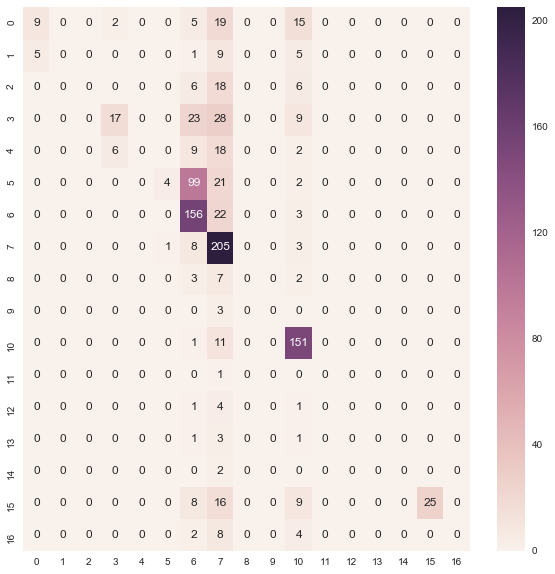

In [45]:
# Test the confusion matric 
# plot heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sn
test_labels = test_labels[:1000]
conf_matx = confusion_matrix(test_labels, predict)

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(conf_matx, annot=True, fmt='d')

# plt.show()

In [46]:
test_data[:2]

493080    Someone has used my identity to open multiple ...
929599    I had a new car loan through XXXX ( Nissan Mot...
Name: complaint, dtype: object

In [47]:
# Test with test data and check the prediction
for request in test_data:
    predict = clf.predict(vectorizer.transform([request]))
    print("Predicted = {}", predict)
    

Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [10]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [3]
Predicted = {} [7]
Predicted = {} [5]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [15]
Predicted = {} [0]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [6]
P

Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [10]
Predicted = {} [15]
Predicted = {} [15]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [

Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [0]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [3]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [7]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [6]
Predicted = {} [10]
Predicted = {} [7]
P

In [48]:
print(test_data[:1])
print(predict[:1])


493080    Someone has used my identity to open multiple ...
Name: complaint, dtype: object
[6]


In [94]:
from sklearn import metrics
print(metrics.classification_report(test_labels, predict, target_names=df_cat['Product'].unique()))


                                                                              precision    recall  f1-score   support

                                                            Credit reporting       0.64      0.18      0.28        50
                                                               Consumer Loan       0.00      0.00      0.00        20
                                                             Debt collection       0.00      0.00      0.00        30
                                                                    Mortgage       0.68      0.22      0.33        77
                                                                 Credit card       0.00      0.00      0.00        35
                                                     Other financial service       0.80      0.03      0.06       126
                                                     Bank account or service       0.48      0.86      0.62       181
                                                       

## Pipeline
###  Pipeline utility :  To manipulate data and many data transformations. So we will utilize pipeline to train every classifier.

In [51]:
# create Pipeline 
# test with Multinomial NB
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

### Train Model

In [52]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])

In [53]:
## Extracting features from text
text_clf.fit(train_data, train_labels)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [54]:
# Test the prediction of classifier with prediction data
predict_pipeline = text_clf.predict(test_data)

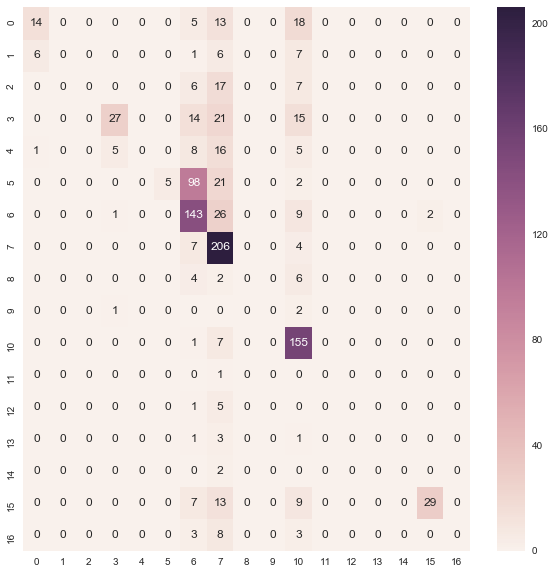

In [55]:
# Check the confusion matrix with pipeline
# plot heatmap to see the rresults
from sklearn.metrics import confusion_matrix
import seaborn as sn
conf_matx_pipeline = confusion_matrix(test_labels[:1000], predict_pipeline[:1000])

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(conf_matx_pipeline, annot=True, fmt='d')

In [56]:
# Measure Accuracy using Precision, recall and F1 score.

from sklearn import metrics
print(metrics.classification_report(test_labels, predict_pipeline, 
                                    target_names=df_cat['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                            Credit reporting       0.67      0.28      0.39        50
                                                               Consumer Loan       0.00      0.00      0.00        20
                                                             Debt collection       0.00      0.00      0.00        30
                                                                    Mortgage       0.79      0.35      0.49        77
                                                                 Credit card       0.00      0.00      0.00        35
                                                     Other financial service       1.00      0.04      0.08       126
                                                     Bank account or service       0.48      0.79      0.60       181
                                                       

In [61]:
# Calculate mean for MultinomialNB
np.mean(predict_pipeline == test_labels) 

0.579

## SVM 

###  Test the prediction using SVM classifier 

In [62]:
# build pipe line for SVM classifier
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=42)),])



In [63]:
# Fit the model
text_clf_svm.fit(train_data, train_labels)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [64]:
# Predict the outcome with SVM 
predict_svm = text_clf_svm.predict(test_data)

In [65]:
# Check the mean accuracy 
np.mean(predict_pipeline == test_labels) 

0.579

## Tuning with Hyperparameter

MultinomialNB includes a smoothing parameter alpha and 

SGDClassifier has a penalty parameter alpha and configurable loss and 
penalty terms in the objective function 

### GridSearchCV

In [66]:
from sklearn.model_selection import GridSearchCV
#  penalty parameter of either 0.01 or 0.001 for the linear SVM
param = {'vect__ngram_range': [(1, 1), (1, 2)],
         'tfidf__use_idf': (True, False),
         'clf__alpha': (1e-2, 1e-3),
         }

In [67]:
# Use Grid search CV 
gsCV_clf = GridSearchCV(text_clf, param, n_jobs=-1)

In [68]:
# Fit the GridSearchCV
gsCV_clf = gsCV_clf.fit(train_data, train_labels)

In [80]:
# Predict the results with test data
predict_gsCV = gsCV_clf.predict(test_data[:2000])

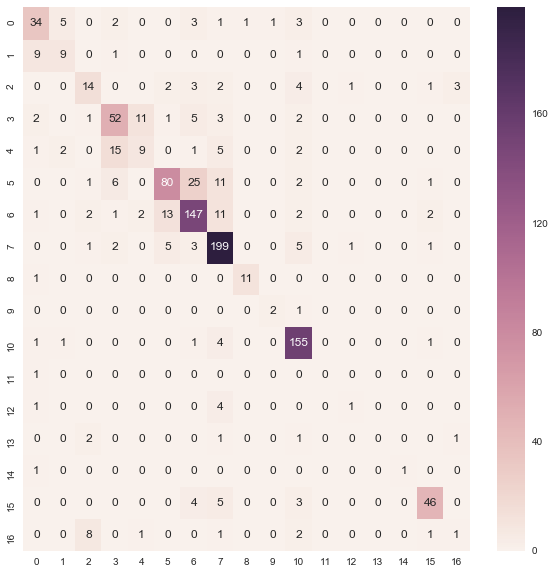

In [87]:
# Build Confusion matrix
# Check with heatmap.
conf_matx_gsCV = confusion_matrix(test_labels[:2000], predict_gsCV)

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(conf_matx_gsCV, annot=True, fmt='d')

In [86]:
# test performance using Precision, recall and F1-score
print(metrics.classification_report(test_labels[:2000], predict_gsCV, 
                                    target_names=df_cat['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                            Credit reporting       0.65      0.68      0.67        50
                                                               Consumer Loan       0.53      0.45      0.49        20
                                                             Debt collection       0.48      0.47      0.47        30
                                                                    Mortgage       0.66      0.68      0.67        77
                                                                 Credit card       0.39      0.26      0.31        35
                                                     Other financial service       0.79      0.63      0.70       126
                                                     Bank account or service       0.77      0.81      0.79       181
                                                       

In [83]:
np.mean(predict_gsCV == test_labels[:2000]) 

0.761

## Conclusion

###  After tuning with hyperparameters , the prediction score has improved sigificantly.

###  Precision    : 0.74
###  Recall          : 0.76
### F1-Score      : 0.75

### Mean Score : 0.761